---
# House Rent Prediction
---

#### Check out the Dataset-Glossory.txt and readme.txt file

| Column Name       | Description                                                |
|-------------------|------------------------------------------------------------|
| BHK               | Number of Bedrooms, Hall, Kitchen                          |
| Rent              | Rent of the Houses/Apartments/Flats                        |
| Size              | Size of the Houses/Apartments/Flats in Square Feet         |
| Floor             | Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.) |
| Area Type         | Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area |
| Area Locality     | Locality of the Houses/Apartments/Flats                   |
| City              | City where the Houses/Apartments/Flats are Located        |
| Furnishing Status | Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished |
| Tenant Preferred  | Type of Tenant Preferred by the Owner or Agent            |
| Bathroom          | Number of Bathrooms                                       |
| Point of Contact  | Whom should you contact for more information regarding the Houses/Apartments/Flats |

### Import Libraries

In [235]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import statistics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
import tensorflow as tf
from sklearn import metrics
from sklearn import model_selection
from sklearn import ensemble, tree, linear_model

In [236]:
hd = pd.read_csv('House_Rent_Dataset.csv')
print("(rows, columns) :", hd.shape)
hd.sample(5)

(rows, columns) : (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
2544,2022-07-04,3,10500,1200,1 out of 4,Super Area,Najafgarh,Delhi,Semi-Furnished,Bachelors/Family,2,Contact Owner
3734,2022-07-06,2,11000,700,1 out of 3,Super Area,Tharamani,Chennai,Unfurnished,Bachelors/Family,1,Contact Owner
4297,2022-05-12,1,3300,200,Ground out of 2,Super Area,Moula Ali,Hyderabad,Unfurnished,Bachelors/Family,1,Contact Owner
4373,2022-07-06,3,28000,1600,1 out of 6,Super Area,Chanda Nagar,Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
706,2022-07-09,3,230000,1915,3 out of 18,Super Area,"Ashok tower, Parel",Mumbai,Semi-Furnished,Bachelors/Family,3,Contact Agent


In [237]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [238]:
# hd.isnull().sum()
# No null values

### Dealing with Outliers

In [239]:
def var_summary(x):
# UC = MEAN + 2 STD
    uc = x.mean()+(2*x.std())
    lc = x.mean()-(2*x.std())
    
    for i in x:
        if i<lc or i>uc:
            count = 1             # This means that column is having an OUTLier
        else:
            count = 0             # That column in not having an outliers
            
    outlier_flag = count
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), 
                      x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),x.quantile(0.10),
                      x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                      x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max() , 
                      lc , uc,outlier_flag],
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                         'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,
                         'MAX','LC','UC','outlier_flag'])

In [240]:
numeric_cols = []
for cols in hd:
    if hd[cols].dtypes == 'int64':
        numeric_cols.append(cols)
        
print(numeric_cols)

['BHK', 'Rent', 'Size', 'Bathroom']


In [241]:
hd[numeric_cols].apply(lambda x: var_summary(x))

,BHK,Rent,Size,Bathroom
N,4746.000000,4.746000e+03,4.746000e+03,4746.000000
NMISS,0.000000,0.000000e+00,0.000000e+00,0.000000
SUM,9890.000000,1.660789e+08,4.591711e+06,9330.000000
MEAN,2.083860,3.499345e+04,9.674907e+02,1.965866
MEDIAN,2.000000,1.600000e+04,8.500000e+02,2.000000
STD,0.832256,7.810641e+04,6.342023e+02,0.884532
VAR,0.692650,6.100612e+09,4.022126e+05,0.782396
MIN,1.000000,1.200000e+03,1.000000e+01,1.000000
P1,1.000000,4.000000e+03,7.000000e+01,1.000000
P5,1.000000,6.000000e+03,2.000000e+02,1.000000


#### Nah I dont believe this, lets plot the taget variable

<Axes: xlabel='Rent'>

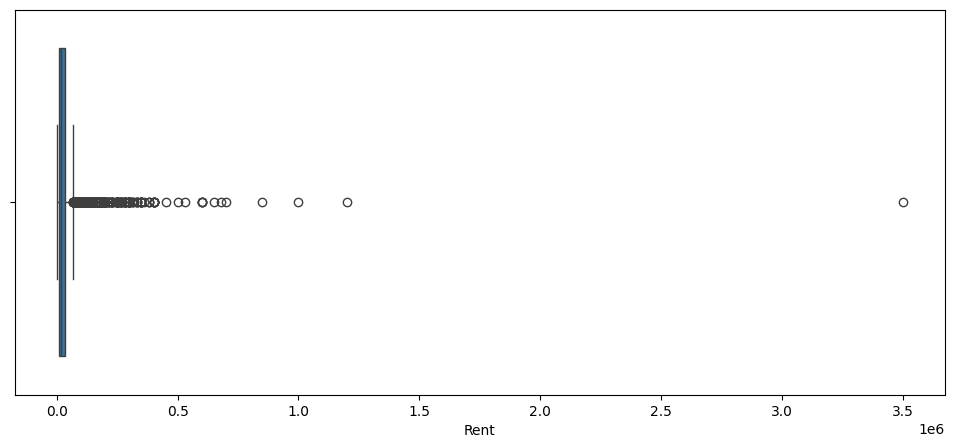

In [242]:
plt.figure(figsize=(12,5))
sns.boxplot(data = hd, x = 'Rent')

In [243]:
hd = hd[hd['Rent'] <= 200000]

<Axes: xlabel='Rent'>

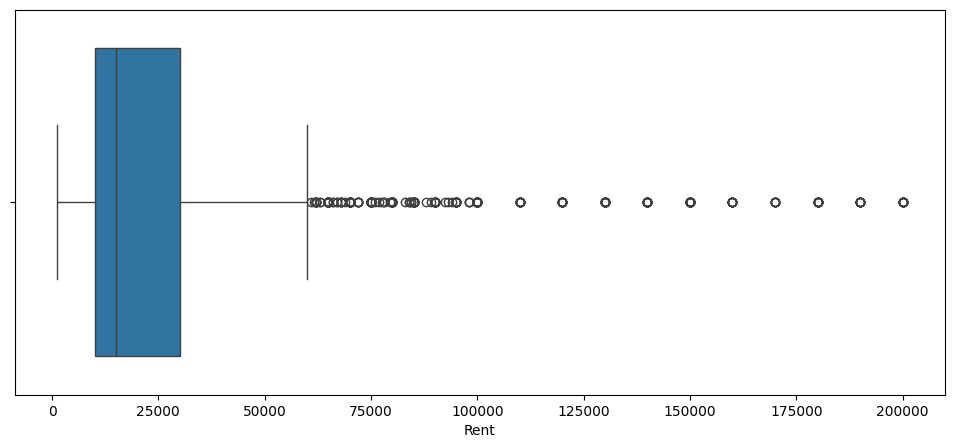

In [244]:
plt.figure(figsize=(12,5))
sns.boxplot(data = hd, x = 'Rent')

### Data Visualization

<Axes: xlabel='City', ylabel='Rent'>

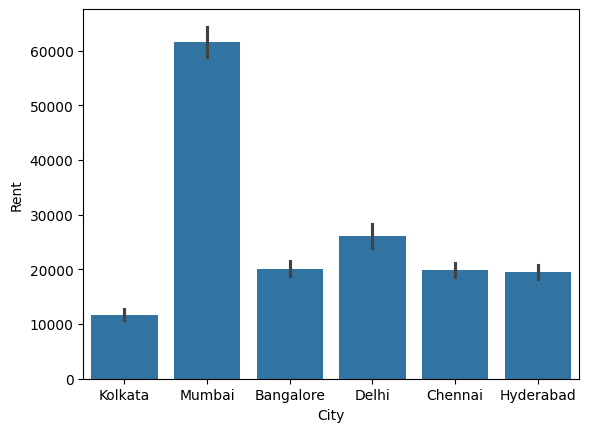

In [245]:
sns.barplot(data = hd, x = 'City', y = 'Rent')
# It seems that Mumbai has the highest Rent amongst all other 

In [246]:
hd['Area Type'].value_counts()

Area Type
Super Area     2436
Carpet Area    2209
Built Area        2
Name: count, dtype: int64

<Axes: xlabel='City', ylabel='Rent'>

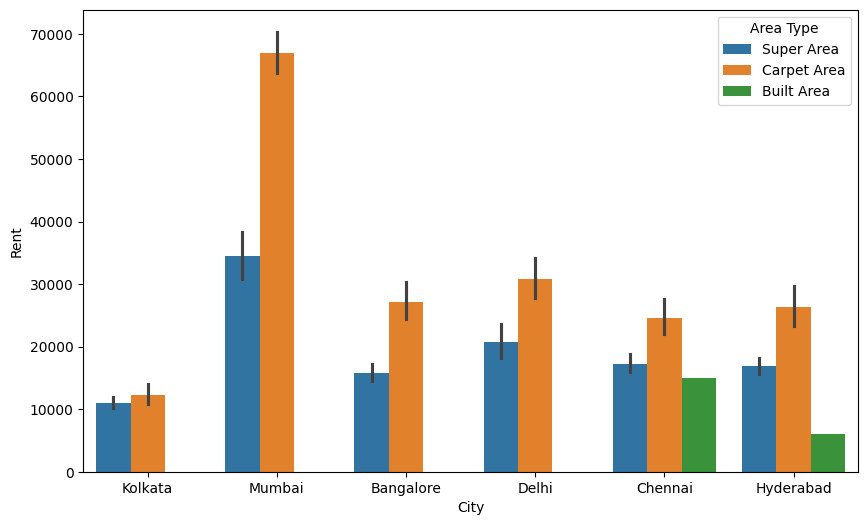

In [247]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Area Type')

<Axes: xlabel='City', ylabel='Rent'>

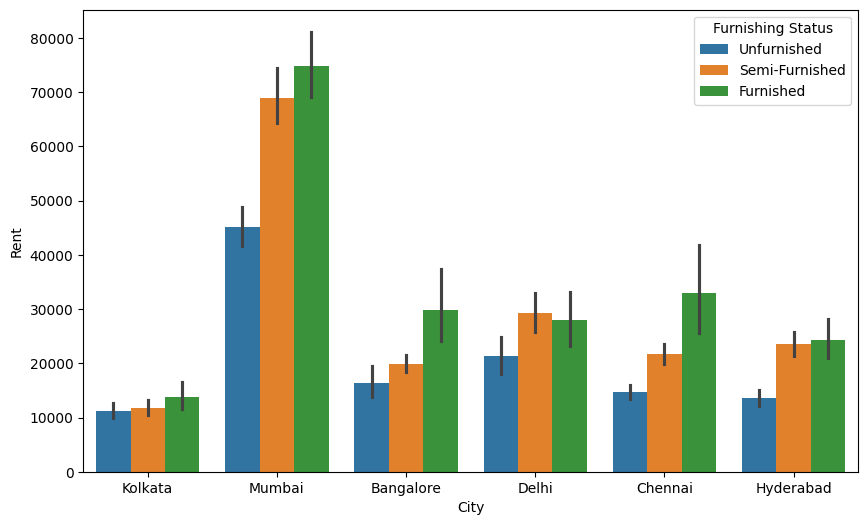

In [248]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Furnishing Status')

<Axes: xlabel='City', ylabel='Rent'>

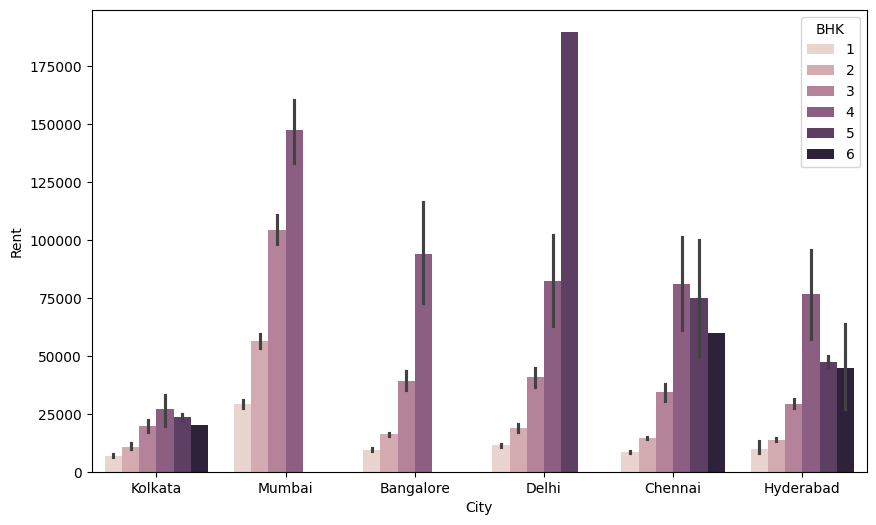

In [249]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'BHK')

In [250]:
hd[hd['BHK'] == 6]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
83,2022-06-21,6,20000,1000,1 out of 1,Super Area,Sonarpur,Kolkata,Semi-Furnished,Bachelors/Family,2,Contact Owner
3584,2022-06-02,6,60000,1800,1 out of 3,Super Area,Besant Nagar,Chennai,Furnished,Bachelors/Family,6,Contact Owner
4350,2022-06-18,6,60000,2800,Ground out of 3,Super Area,"Boduppal, NH 2 2",Hyderabad,Furnished,Bachelors/Family,7,Contact Owner
4479,2022-07-07,6,20000,2400,Ground out of 1,Super Area,"Mallikarjuna Nagar, Secunderabad",Hyderabad,Unfurnished,Family,4,Contact Owner
4518,2022-05-12,6,35000,3400,Ground out of 2,Super Area,Rampally,Hyderabad,Unfurnished,Bachelors/Family,7,Contact Owner
4648,2022-07-06,6,80000,4500,1 out of 2,Super Area,"Kakateeya Nagar, Secunderabad",Hyderabad,Semi-Furnished,Bachelors/Family,6,Contact Owner
4696,2022-07-06,6,30000,4200,Ground out of 2,Super Area,Kuntloor,Hyderabad,Semi-Furnished,Bachelors/Family,5,Contact Owner


<Axes: xlabel='City', ylabel='Rent'>

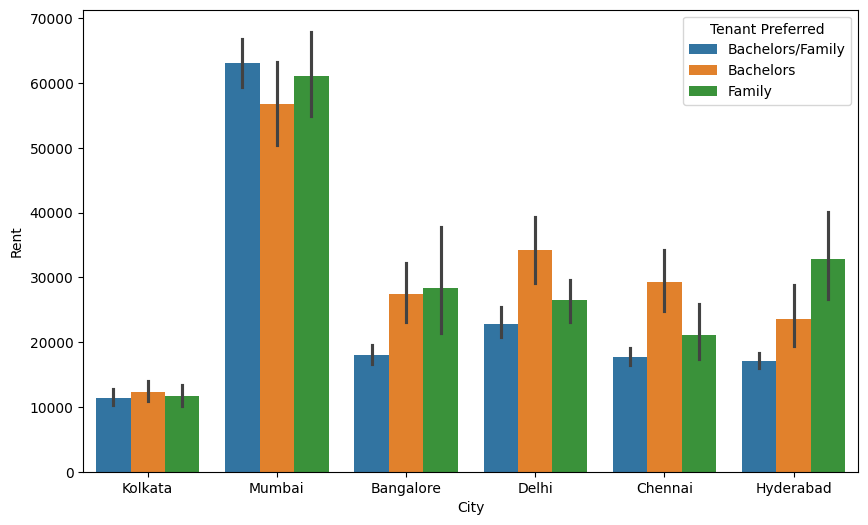

In [251]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Tenant Preferred')

In [252]:
hd['Bathroom'].value_counts()

Bathroom
2     2285
1     1474
3      732
4      116
5       28
6        8
7        3
10       1
Name: count, dtype: int64

In [253]:
hd.describe()

,BHK,Rent,Size,Bathroom
count,4647.000000,4647.000000,4647.000000,4647.000000
mean,2.047558,27720.877986,935.207661,1.920164
std,0.795284,31960.289864,581.327095,0.824634
min,1.000000,1200.000000,10.000000,1.000000
25%,1.000000,10000.000000,550.000000,1.000000
50%,2.000000,15000.000000,825.000000,2.000000
75%,3.000000,30000.000000,1200.000000,2.000000
max,6.000000,200000.000000,8000.000000,10.000000


In [254]:
hd1 = hd.copy()

In [255]:
hd1.sample(5)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
2339,2022-05-05,3,22000,1200,2 out of 4,Super Area,Annapurneshwari Nagar,Bangalore,Furnished,Bachelors/Family,2,Contact Owner
3562,2022-06-18,2,13000,1260,Ground out of 1,Super Area,Porur,Chennai,Semi-Furnished,Bachelors/Family,3,Contact Owner
3264,2022-07-04,3,20000,1650,1 out of 1,Carpet Area,Madipakkam,Chennai,Semi-Furnished,Bachelors,3,Contact Owner
2481,2022-07-07,3,35000,950,1 out of 4,Carpet Area,Karol Bagh,Delhi,Furnished,Bachelors,2,Contact Agent
3302,2022-07-06,3,46000,1700,15 out of 18,Super Area,Thoraipakkam,Chennai,Semi-Furnished,Bachelors/Family,3,Contact Agent


In [256]:
drop_col = ['Posted On', 'Floor', 'Area Locality', 'Point of Contact']
hd1.drop(columns=drop_col, inplace = True)

In [257]:
hd1 = hd1[hd1['Area Type'] != 'Built Area']

In [258]:
hd1.sample(5)

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
1732,2,23000,600,Super Area,Bangalore,Semi-Furnished,Bachelors/Family,2
2443,2,25000,100,Carpet Area,Delhi,Unfurnished,Bachelors,2
2848,4,110000,3000,Carpet Area,Delhi,Semi-Furnished,Bachelors,5
788,3,200000,1208,Carpet Area,Mumbai,Unfurnished,Bachelors,3
2003,3,24000,1550,Carpet Area,Bangalore,Semi-Furnished,Bachelors,3


In [259]:
hd1['Furnishing Status'].value_counts()

Furnishing Status
Semi-Furnished    2198
Unfurnished       1801
Furnished          646
Name: count, dtype: int64

In [260]:
hd1['Area Type'].value_counts()

Area Type
Super Area     2436
Carpet Area    2209
Name: count, dtype: int64

In [261]:
hd1['Furnishing Status'] = hd1['Furnishing Status'].replace(['Furnished', 'Semi-Furnished','Unfurnished'], [2, 1, 0])
hd1['Area Type'] = hd1['Area Type'].replace(['Super Area','Carpet Area'],[1,0])

In [262]:
hd1['Furnishing Status'].value_counts()

Furnishing Status
1    2198
0    1801
2     646
Name: count, dtype: int64

In [263]:
hd1['Area Type'].value_counts()

Area Type
1    2436
0    2209
Name: count, dtype: int64